In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
torch.backends.cudnn.benchmark = True

In [2]:
image_size = 64
def get_transform():
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    return transform

In [3]:
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) 
                            if fname.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img

In [4]:
dataset = AnimeFaceDataset(root_dir='/kaggle/input/animefacedataset/images', transform=get_transform())

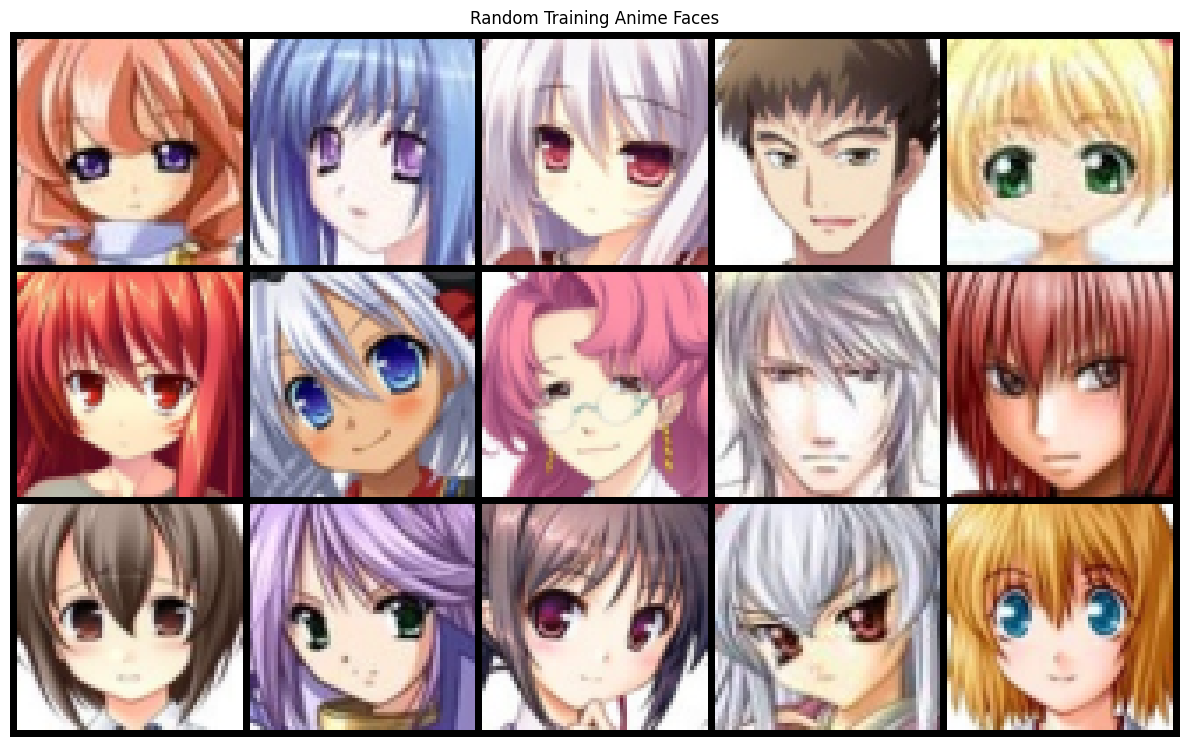

In [5]:
torch.manual_seed(42)
indices = torch.randperm(len(dataset))[:15]
selected_images = torch.stack([dataset[i] for i in indices])

def denormalize(images):
    return images * 0.5 + 0.5

plt.figure(figsize=(12, 8))
plt.title("Random Training Anime Faces")
grid = vutils.make_grid(denormalize(selected_images), nrow = 5, normalize=False)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

## Designing a generator in DCGAN

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # latent vector
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

## A discriminator in DCGAN

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

## Training and using DCGAN

In [8]:
class TrainAnime:
    def __init__(self):
        self.train_iterator = None
        self.valid_iterator = None
        self.test_iterator = None

        self.image_size = 64
        self.latent_dim = 300        
        self.beta1 = 0.5

        # define batch size
        self.batch_size = 1024

        # Number of training epochs
        self.num_epochs = 250

        # Learning rate
        self.lr = 0.0002
       
        # set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

        self.net_g = Generator(self.latent_dim).to(self.device)
        self.net_d = Discriminator().to(self.device)

        # set optimizer
        self.criterion = nn.BCELoss()
        self.optimizer_d = optim.Adam(self.net_d.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.optimizer_g = optim.Adam(self.net_g.parameters(), lr=self.lr, betas=(self.beta1, 0.999))


    def load_dataset(self):                
        dataset = AnimeFaceDataset(root_dir='/kaggle/input/animefacedataset/images', 
                                   transform=get_transform())

        self.train_iterator = DataLoader(dataset=dataset, 
                                         batch_size=self.batch_size, 
                                         shuffle=True, 
                                         num_workers=8)
        print('Load data done!')

    def train_data(self):    
        print("Start training...")
        for epoch in range(self.num_epochs):
            for i, real_images in enumerate(self.train_iterator):
                real_images = real_images.to(self.device)
                batch_size = real_images.size(0)
                
                # create fake/real label
                real_label = torch.ones(batch_size).to(self.device)
                fake_label = torch.zeros(batch_size).to(self.device)
                
                # discrimitnator with grad zero
                self.net_d.zero_grad()
                
                # forward to discriminator
                output = self.net_d(real_images)
                errD_real = self.criterion(output, real_label*0.9)
                #errD_real.backward()
                
                # 
                noise = torch.randn(batch_size, self.latent_dim, 1, 1).to(self.device)
                fake_images = self.net_g(noise)
                output = self.net_d(fake_images.detach())
                errD_fake = self.criterion(output, fake_label)
                #errD_fake.backward()
                
                errD = errD_real + errD_fake
                errD.backward()
                self.optimizer_d.step()
                
                # 
                self.net_g.zero_grad()
                output = self.net_d(fake_images)
                errG = self.criterion(output, real_label)
                errG.backward()
                self.optimizer_g.step()
                
                if i % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.num_epochs}], {i}/{len(self.train_iterator)}. Loss_D: {errD.item():.4f}, Loss_G: {errG.item():.4f}')
        
        # Save MODELS
        torch.save(self.net_g.state_dict(), '/kaggle/working/generator_model.pth')
        torch.save(self.net_d.state_dict(), '/kaggle/working/discriminator_model.pth')
        print('Finished Training')

    def test_dcgan(self):
        # Test pretrained model
        self.net_g.eval()
        with torch.no_grad():
            noise = torch.randn(15, self.latent_dim, 1, 1).to(self.device)
            generated_images = self.net_g(noise).cpu()
            
            # generate images
            generated_images = generated_images * 0.5 + 0.5
            
            # plot
            plt.figure(figsize=(12, 8))
            plt.title("Generated Anime Faces")
            plt.imshow(np.transpose(vutils.make_grid(generated_images, nrow=5, normalize=False), (1,2,0)))
            plt.axis('off')
            plt.show()
            plt.savefig('generated_anime_faces.png')
            plt.close()
        
        print("generated_anime_faces.png")

Load data done!
Start training...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/250], 0/63. Loss_D: 1.3444, Loss_G: 2.7465
Epoch [1/250], 10/63. Loss_D: 0.4302, Loss_G: 6.6685
Epoch [1/250], 20/63. Loss_D: 0.3965, Loss_G: 7.4006
Epoch [1/250], 30/63. Loss_D: 0.8642, Loss_G: 16.2435
Epoch [1/250], 40/63. Loss_D: 0.4439, Loss_G: 4.4449
Epoch [1/250], 50/63. Loss_D: 0.7027, Loss_G: 5.1323
Epoch [1/250], 60/63. Loss_D: 0.8962, Loss_G: 5.7668
Epoch [2/250], 0/63. Loss_D: 0.6945, Loss_G: 4.6182
Epoch [2/250], 10/63. Loss_D: 0.8860, Loss_G: 3.6620
Epoch [2/250], 20/63. Loss_D: 1.3015, Loss_G: 4.4802
Epoch [2/250], 30/63. Loss_D: 0.8548, Loss_G: 3.8438
Epoch [2/250], 40/63. Loss_D: 0.8172, Loss_G: 5.1342
Epoch [2/250], 50/63. Loss_D: 0.7557, Loss_G: 3.4778
Epoch [2/250], 60/63. Loss_D: 0.8882, Loss_G: 6.1860
Epoch [3/250], 0/63. Loss_D: 0.7787, Loss_G: 6.6156
Epoch [3/250], 10/63. Loss_D: 0.6357, Loss_G: 4.6293
Epoch [3/250], 20/63. Loss_D: 0.5169, Loss_G: 4.7393
Epoch [3/250], 30/63. Loss_D: 0.6970, Loss_G: 3.1955
Epoch [3/250], 40/63. Loss_D: 0.8607, Loss_G: 4.

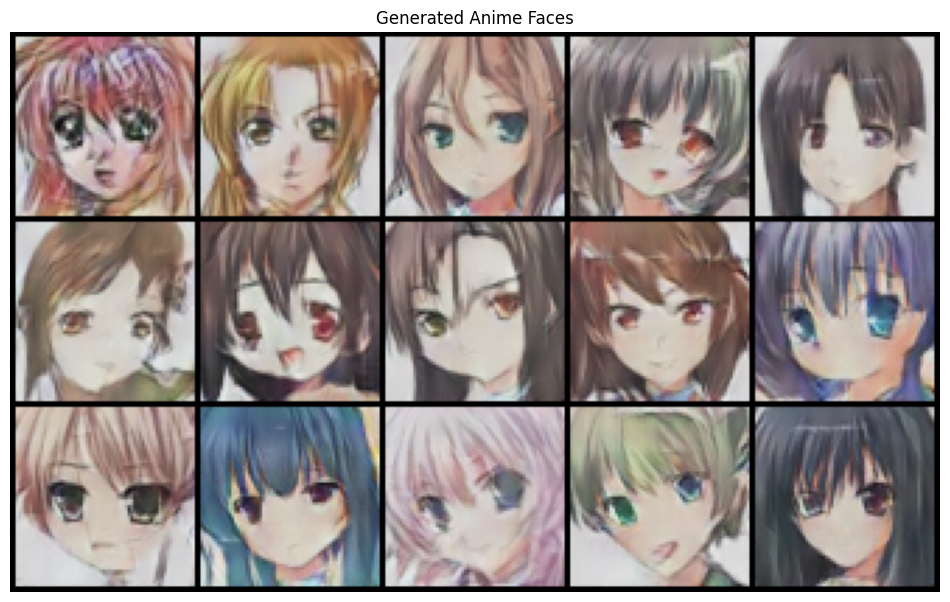

generated_anime_faces.png


In [9]:
if __name__ == '__main__':
    trainer = TrainAnime()
    trainer.load_dataset()
    trainer.train_data()
    trainer.test_dcgan()